In [2]:
#!/usr/bin/env python
# coding: utf-8

# # Fixed Relative Accuracy Analysis - Handles Format Mismatch
# 
# This version correctly handles the format differences between extractions and ground truth

import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set paths
EXTRACTION_PATH = Path(r"E:\langchain\Dissertation\data\extractions")
GROUND_TRUTH_PATH = Path(r"E:\langchain\Dissertation\data\ground_truth")
RESULTS_PATH = Path(r"E:\langchain\Dissertation\results")
RESULTS_PATH.mkdir(exist_ok=True)

print("GPT-4V Chart Extraction Relative Accuracy Analysis (FIXED)")
print("=" * 60)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

GPT-4V Chart Extraction Relative Accuracy Analysis (FIXED)
Analysis Date: 2025-07-30 15:54:57


#### SECTION 1. Load Data Functions

In [3]:
def load_extraction_results():
    """Load all extraction results from JSON files"""
    extractions = {}
    json_files = list(EXTRACTION_PATH.glob("*.json"))
    
    for json_file in json_files:
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                extractions[json_file.stem] = data
        except Exception as e:
            print(f"Error loading {json_file.name}: {e}")
    
    print(f"\nLoaded {len(extractions)} extraction results")
    return extractions

def load_ground_truth():
    """Load ground truth data from chart_configurations.json"""
    ground_truth = {}
    
    config_file = GROUND_TRUTH_PATH / "chart_configurations.json"
    if config_file.exists():
        with open(config_file, 'r') as f:
            configs = json.load(f)
            for config in configs:
                ground_truth[config['id']] = config
        print(f"Loaded {len(ground_truth)} ground truth entries")
    else:
        print("WARNING: chart_configurations.json not found!")
    
    return ground_truth

# Load data
extractions = load_extraction_results()
ground_truth = load_ground_truth()


Loaded 1399 extraction results
Loaded 200 ground truth entries


#### 2. Metric Calculation Functions

In [10]:
def normalize_extraction_data(extracted_data):
    """Normalize extraction data to standard format"""
    normalized = []
    
    if isinstance(extracted_data, list):
        for item in extracted_data:
            if isinstance(item, dict) and 'category' in item and 'value' in item:
                # Split combined category-series format
                category = item['category']
                value = float(item['value']) if item['value'] is not None else 0.0
                normalized.append({'category': category, 'value': value})
    
    elif isinstance(extracted_data, dict):
        for key, value in extracted_data.items():
            normalized.append({'category': key, 'value': float(value) if value is not None else 0.0})
    
    return normalized

def normalize_extraction_data(extracted_data):
    """Normalize extraction data to standard format"""
    normalized = []

    if isinstance(extracted_data, list):
        for item in extracted_data:
            if isinstance(item, dict) and 'category' in item and 'value' in item:
                category = item['category']
                raw_value = item['value']
                
                try:
                    # Attempt to cast to float if possible
                    value = float(raw_value) if isinstance(raw_value, (int, float, str)) else 0.0
                except (ValueError, TypeError):
                    value = 0.0
                
                normalized.append({'category': category, 'value': value})

    elif isinstance(extracted_data, dict):
        for key, value in extracted_data.items():
            try:
                normalized.append({
                    'category': key,
                    'value': float(value) if isinstance(value, (int, float, str)) else 0.0
                })
            except (ValueError, TypeError):
                normalized.append({
                    'category': key,
                    'value': 0.0
                })

    return normalized



def calculate_exact_match_fixed(extracted, expected):
    """Calculate exact match with normalized data"""
    if not extracted or not expected:
        return 0.0
    
    # Normalize both datasets
    extracted_norm = normalize_extraction_data(extracted)
    expected_norm = normalize_ground_truth_data(expected) if isinstance(expected, dict) else expected
    
    if len(extracted_norm) != len(expected_norm):
        return 0.0
    
    # Create value maps for comparison
    extracted_map = {item['category'].lower(): item['value'] for item in extracted_norm}
    expected_map = {item['category'].lower(): item['value'] for item in expected_norm}
    
    # Check if all values match (with tolerance)
    if set(extracted_map.keys()) != set(expected_map.keys()):
        return 0.0
    
    for key in expected_map:
        if abs(extracted_map.get(key, -999) - expected_map[key]) >= 0.1:
            return 0.0
    
    return 1.0

def calculate_f1_score_fixed(extracted, expected):
    """Calculate F1 score with better matching"""
    if not extracted or not expected:
        return 0.0
    
    # Normalize data
    extracted_norm = normalize_extraction_data(extracted)
    expected_norm = normalize_ground_truth_data(expected) if isinstance(expected, dict) else expected
    
    # Extract values for comparison
    extracted_values = [(item['category'].lower(), item['value']) for item in extracted_norm]
    expected_values = [(item['category'].lower(), item['value']) for item in expected_norm]
    
    # Calculate matches
    true_positives = 0
    
    for e_cat, e_val in extracted_values:
        for g_cat, g_val in expected_values:
            # Flexible matching: partial category match OR exact value match
            cat_match = any(part in e_cat for part in g_cat.split()) or any(part in g_cat for part in e_cat.split())
            val_match = abs(e_val - g_val) < 0.1
            
            if cat_match and val_match:
                true_positives += 1
                break
    
    precision = true_positives / len(extracted_values) if extracted_values else 0
    recall = true_positives / len(expected_values) if expected_values else 0
    
    if precision + recall == 0:
        return 0.0
    
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def calculate_value_accuracy_fixed(extracted, expected):
    """Calculate value accuracy with 10% tolerance"""
    if not extracted or not expected:
        return 0.0
    
    # Normalize data
    extracted_norm = normalize_extraction_data(extracted)
    expected_norm = normalize_ground_truth_data(expected) if isinstance(expected, dict) else expected
    
    # Get all values
    extracted_values = [item['value'] for item in extracted_norm]
    expected_values = [item['value'] for item in expected_norm]
    
    if not expected_values:
        return 0.0
    
    # Match values with tolerance
    matched = 0
    for e_val in expected_values:
        tolerance = abs(e_val * 0.1)  # 10% tolerance
        for x_val in extracted_values:
            if abs(x_val - e_val) <= tolerance:
                matched += 1
                break
    
    return (matched / len(expected_values)) * 100

def calculate_chart_type_accuracy_fixed(extracted_type, expected_type):
    """Fixed chart type matching with common variations"""
    if not extracted_type or not expected_type:
        return 0.0
    
    # Normalize types
    extracted_lower = extracted_type.lower().strip()
    expected_lower = expected_type.lower().strip()
    
    # Direct match
    if extracted_lower == expected_lower:
        return 1.0
    
    # Common equivalences
    equivalences = {
        'bar': ['bar', 'column', 'grouped_bar', 'stacked_bar'],
        'line': ['line', 'lines', 'line_chart'],
        'scatter': ['scatter', 'scatterplot', 'scatter_plot'],
        'pie': ['pie', 'pie_chart'],
        'area': ['area', 'area_chart', 'stacked_area']
    }
    
    # Check equivalences
    for key, variants in equivalences.items():
        if expected_lower in variants and extracted_lower in variants:
            return 1.0
    
    return 0.0

#### 3. Process All Extractions

In [11]:
import re

def evaluate_extraction_fixed(extraction_key, extraction_data, ground_truth_data):
    """Evaluate extraction with fixed format handling"""
    
    # Robustly extract chart ID (e.g., chart_001)
    match = re.match(r"(chart_\d{3})", extraction_key)
    chart_id = match.group(1) if match else None
    if not chart_id or chart_id not in ground_truth_data:
        return None
    
    # Determine if original or perturbation
    is_original = extraction_key.endswith('_original')
    
    # Get perturbation type
    perturbation_type = 'none'
    if not is_original:
        # Try to find perturbation type from known candidates
        perturbation_candidates = [
            'gaussian_blur', 'rotation', 'random_blocks', 
            'brightness_shift', 'legend_corruption', 'grayscale_conversion'
        ]
        for pert in perturbation_candidates:
            if pert in extraction_key:
                perturbation_type = pert
                break

    # Get ground truth
    gt = ground_truth_data.get(chart_id)
    if not gt:
        return None
    
    # Extract relevant fields
    extracted_data = extraction_data.get('data', [])
    extracted_chart_type = extraction_data.get('chart_type', '')
    expected_chart_type = gt.get('chart_type', '')
    
    # Calculate metrics
    exact_match = calculate_exact_match_fixed(extracted_data, gt)
    f1_score = calculate_f1_score_fixed(extracted_data, gt)
    value_accuracy = calculate_value_accuracy_fixed(extracted_data, gt)
    chart_type_accuracy = calculate_chart_type_accuracy_fixed(extracted_chart_type, expected_chart_type)
    
    return {
        'extraction_key': extraction_key,
        'chart_id': chart_id,
        'is_original': is_original,
        'perturbation_type': perturbation_type,
        'exact_match_accuracy': exact_match,
        'f1_score': f1_score,
        'value_accuracy': value_accuracy,
        'chart_type_accuracy': chart_type_accuracy,
        'extraction_confidence': extraction_data.get('extraction_confidence', 'unknown')
    }

# Process all extractions
print("\n" + "="*60)
print("Processing extractions with fixed format handling...")

results = []
failed_count = 0

for key, extraction in extractions.items():
    result = evaluate_extraction_fixed(key, extraction, ground_truth)
    if result:
        results.append(result)
    else:
        failed_count += 1

# Add failed extractions
expected_total = 1400
current_total = len(results)
missing_count = expected_total - current_total

print(f"\nExtraction Summary:")
print(f"  Expected: {expected_total}")
print(f"  Processed: {current_total}")
print(f"  Failed/Missing: {missing_count}")

if missing_count > 0:
    for i in range(missing_count):
        results.append({
            'extraction_key': f'failed_extraction_{i}',
            'chart_id': 'failed',
            'is_original': False,
            'perturbation_type': 'failed',
            'exact_match_accuracy': 0.0,
            'f1_score': 0.0,
            'value_accuracy': 0.0,
            'chart_type_accuracy': 0.0,
            'extraction_confidence': 'failed'
        })

# Convert to DataFrame
df_results = pd.DataFrame(results)



Processing extractions with fixed format handling...

Extraction Summary:
  Expected: 1400
  Processed: 1394
  Failed/Missing: 6


### 4. Calculate Relative Accuracy

In [12]:
print("\n" + "="*60)
print("Calculating Relative Accuracy...")

# Calculate composite score for each extraction
df_results['composite_score'] = (
    df_results['exact_match_accuracy'] + 
    df_results['f1_score'] + 
    df_results['value_accuracy'] / 100 +  # Normalize to 0-1 scale
    df_results['chart_type_accuracy']
) / 4 * 100  # Average of 4 metrics, converted to percentage

# Calculate RA for each perturbation
ra_results = []

for chart_id in df_results['chart_id'].unique():
    if chart_id == 'failed':
        continue
    
    # Get original performance
    original_data = df_results[(df_results['chart_id'] == chart_id) & 
                              (df_results['is_original'] == True)]
    
    if len(original_data) == 0:
        continue
    
    original_score = original_data['composite_score'].iloc[0]
    
    # Calculate RA for each perturbation of this chart
    perturbed_data = df_results[(df_results['chart_id'] == chart_id) & 
                               (df_results['is_original'] == False)]
    
    for _, pert_row in perturbed_data.iterrows():
        if original_score > 0:
            ra = (pert_row['composite_score'] / original_score) * 100
        else:
            ra = 0.0  # If original failed, RA is 0
        
        ra_results.append({
            'extraction_key': pert_row['extraction_key'],
            'relative_accuracy': min(ra, 100.0)  # Cap at 100%
        })

# Merge RA back to main dataframe
ra_df = pd.DataFrame(ra_results)
df_results = df_results.merge(ra_df, on='extraction_key', how='left')

# Fill RA for originals (always 100%) and failed (always 0%)
df_results.loc[df_results['is_original'] == True, 'relative_accuracy'] = 100.0
df_results.loc[df_results['perturbation_type'] == 'failed', 'relative_accuracy'] = 0.0



Calculating Relative Accuracy...


### Display results

In [13]:
print("\n" + "="*60)
print("RELATIVE ACCURACY ANALYSIS RESULTS")
print("="*60)

# Overall statistics
originals = df_results[df_results['is_original'] == True]
perturbations = df_results[(df_results['is_original'] == False) & 
                          (df_results['perturbation_type'] != 'failed')]

print("\n1. Overall Performance:")
print(f"\nOriginal Charts (Clean):")
print(f"  Exact Match: {originals['exact_match_accuracy'].mean():.1%}")
print(f"  F1 Score: {originals['f1_score'].mean():.1%}")
print(f"  Value Accuracy: {originals['value_accuracy'].mean():.1f}%")
print(f"  Chart Type: {originals['chart_type_accuracy'].mean():.1%}")

print(f"\nPerturbed Charts:")
print(f"  Exact Match: {perturbations['exact_match_accuracy'].mean():.1%}")
print(f"  F1 Score: {perturbations['f1_score'].mean():.1%}")
print(f"  Value Accuracy: {perturbations['value_accuracy'].mean():.1f}%")
print(f"  Chart Type: {perturbations['chart_type_accuracy'].mean():.1%}")

# RA by perturbation type
print("\n2. Relative Accuracy by Perturbation Type:")
ra_by_type = perturbations.groupby('perturbation_type')['relative_accuracy'].agg(['mean', 'std', 'count'])
ra_by_type = ra_by_type.sort_values('mean', ascending=False)

print("\nPerturbation Type      | Mean RA | Std Dev | Count")
print("-" * 55)
for pert_type, row in ra_by_type.iterrows():
    print(f"{pert_type:20} | {row['mean']:6.1f}% | {row['std']:6.1f}% | {row['count']:5.0f}")

overall_ra = perturbations['relative_accuracy'].mean()
print(f"\nOverall Relative Accuracy: {overall_ra:.1f}%")



RELATIVE ACCURACY ANALYSIS RESULTS

1. Overall Performance:

Original Charts (Clean):
  Exact Match: 0.0%
  F1 Score: 15.7%
  Value Accuracy: 62.1%
  Chart Type: 90.9%

Perturbed Charts:
  Exact Match: 0.0%
  F1 Score: 15.2%
  Value Accuracy: 58.8%
  Chart Type: 91.9%

2. Relative Accuracy by Perturbation Type:

Perturbation Type      | Mean RA | Std Dev | Count
-------------------------------------------------------
legend_corruption    |   96.9% |    9.9% |   197
gaussian_blur        |   96.8% |   12.0% |   198
brightness_shift     |   96.8% |   12.4% |   198
rotation             |   96.7% |   10.3% |   198
grayscale_conversion |   93.2% |   18.3% |   195
random_blocks        |   84.1% |   24.7% |   198

Overall Relative Accuracy: 94.1%


### 6. Save Results


 Results saved to: relative_accuracy_analysis_FIXED_20250730_160513.csv


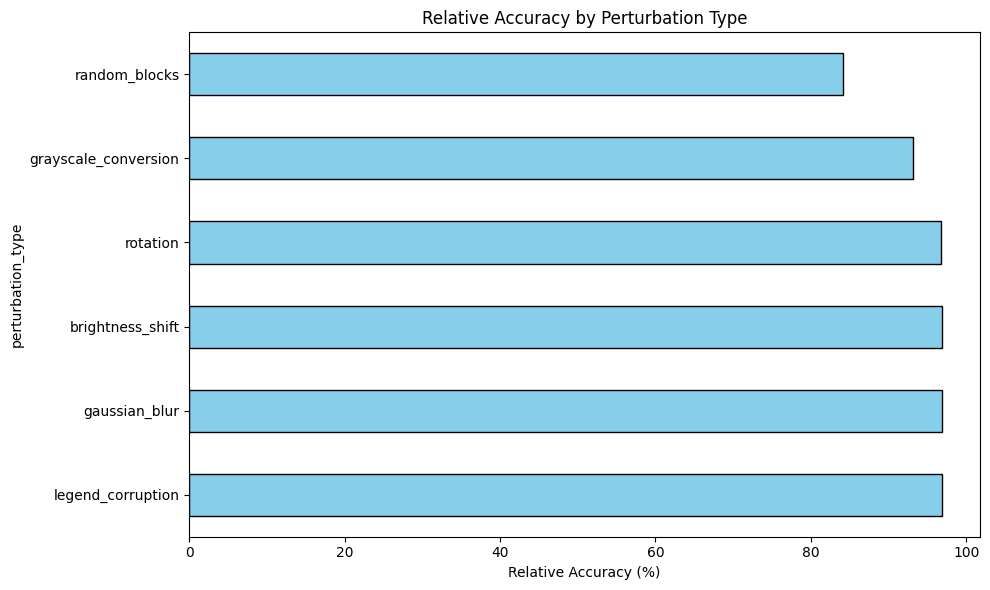


 Analysis complete with fixed format handling!


In [14]:
# Prepare final dataframe
final_columns = [
    'extraction_key', 'chart_id', 'is_original', 'perturbation_type',
    'exact_match_accuracy', 'f1_score', 'value_accuracy', 'chart_type_accuracy',
    'relative_accuracy', 'extraction_confidence'
]

# Ensure relative_accuracy column exists
if 'relative_accuracy' not in df_results.columns:
    df_results['relative_accuracy'] = 0.0

df_final = df_results[final_columns].copy()

# Save results
output_file = RESULTS_PATH / f"relative_accuracy_analysis_FIXED_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df_final.to_csv(output_file, index=False)
print(f"\n Results saved to: {output_file.name}")

# Create visualizations
plt.figure(figsize=(10, 6))
if len(ra_by_type) > 0:
    ra_by_type['mean'].plot(kind='barh', color='skyblue', edgecolor='black')
    plt.xlabel('Relative Accuracy (%)')
    plt.title('Relative Accuracy by Perturbation Type')
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'ra_by_perturbation_FIXED.png', dpi=300)
    plt.show()

print("\n Analysis complete with fixed format handling!")

#### Extraction failure & Analysis

COMPREHENSIVE EXTRACTION AUDIT - NO MODIFICATIONS

STEP 1: Building registry of all expected extractions...
  Found 200 original charts
  Found 1200 perturbation files
  Registry contains 1400 expected extractions

STEP 2: Auditing existing extraction files...
  Found 1399 JSON files in extraction directory
  Regular extraction files: 1394
  Failed extraction files: 5

STEP 3: Processing failure logs...
  Loaded 4 failure log entries

STEP 4: Processing failed extraction files...

STEP 5: Identifying missing extractions...

STEP 6: Generating detailed report...

STEP 7: Analyzing specific problem cases...

  Analysis of chart_182_complex_bar_rotation_medium:
    Status: inconsistent
    File exists: True
    In failure log: False
    JSON valid: Yes
    Extraction time: 2025-07-30T11:32:28.549177
    Attempt: 1

  Analysis of chart_147_complex_line_rotation_medium:
    Status: inconsistent
    File exists: True
    In failure log: False
    JSON valid: Yes
    Extraction time: 2025-07-

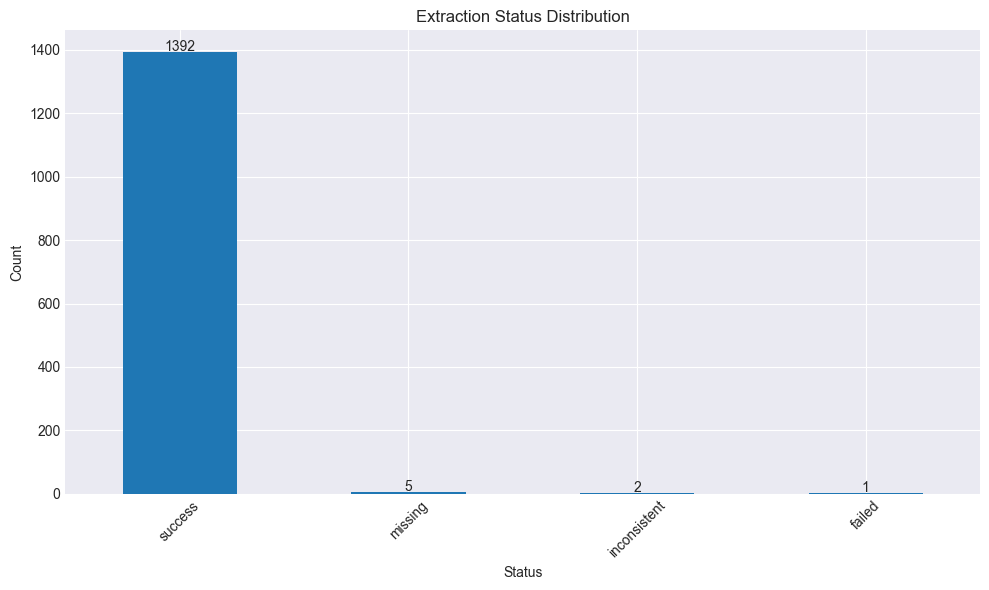

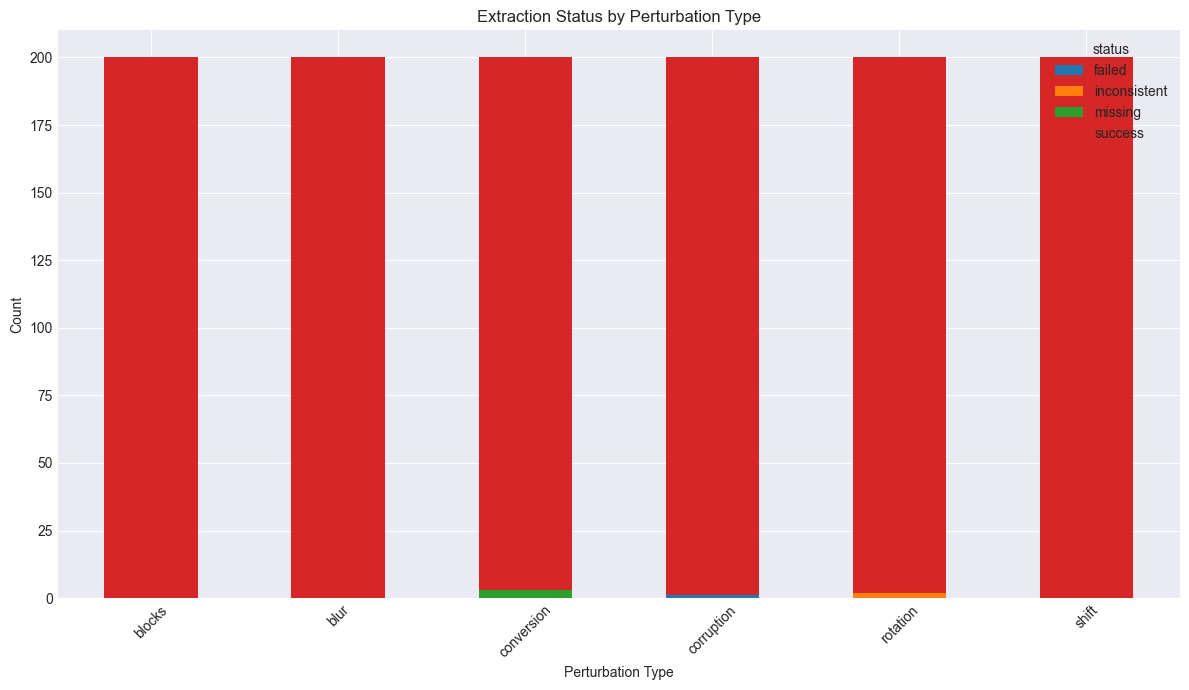

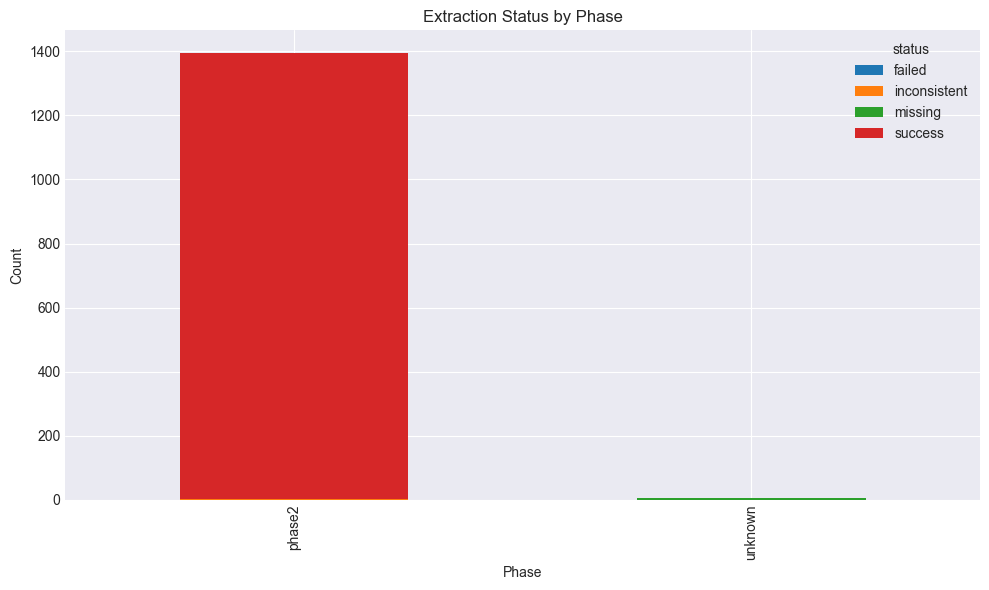

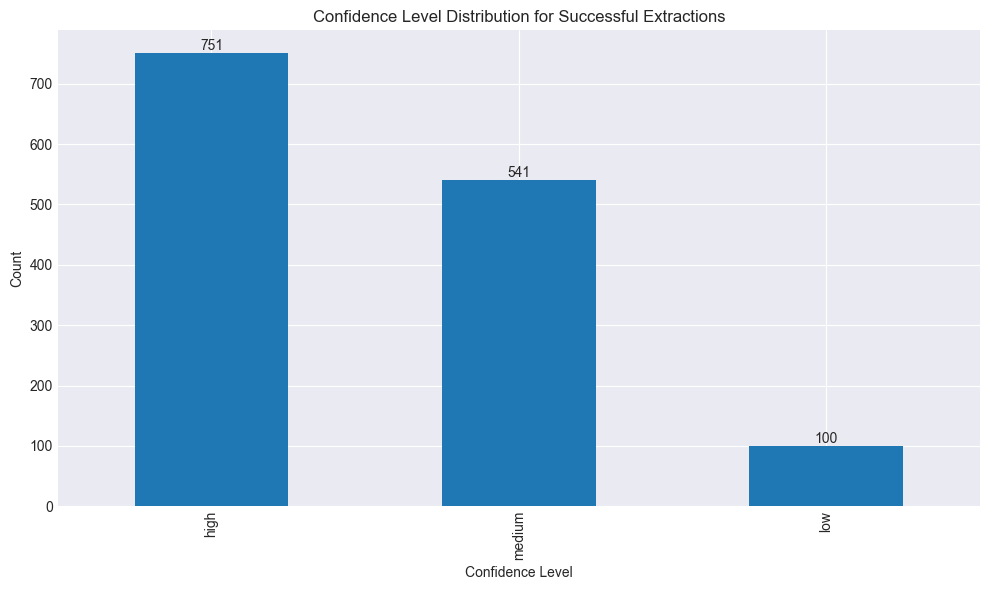

In [6]:
### To check failed extractions: clearly
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_extraction_audit(create_plots=True):
    """
    Performs a comprehensive audit of all extraction data without modifying existing files.
    Analyzes results from both extraction phases and identifies any inconsistencies.
    
    Args:
        create_plots: Whether to create visualization plots (default: True)
    """
    print("=" * 80)
    print("COMPREHENSIVE EXTRACTION AUDIT - NO MODIFICATIONS")
    print("=" * 80)
    
    # Define paths
    extraction_dir = Path("data/extractions")
    perturbation_dir = Path("data/perturbations")
    raw_charts_dir = Path("data/raw_charts")
    logs_dir = Path("data/logs")
    failure_log_path = logs_dir / "extraction_failures.csv"
    analysis_dir = logs_dir / "analysis"
    
    # Create analysis directory if it doesn't exist
    analysis_dir.mkdir(parents=True, exist_ok=True)
    
    # Initialize data structures
    extraction_registry = {}   # Complete registry of all extractions and their status
    extraction_counts = {
        "expected": 0,
        "actual_files": 0,
        "successful": 0,
        "failed": 0,
        "missing": 0,
        "duplicates": 0,
        "inconsistencies": 0
    }
    
    # Step 1: Build a registry of all expected extractions
    print("\nSTEP 1: Building registry of all expected extractions...")
    
    # Load original chart files
    raw_charts = list(raw_charts_dir.glob("*.png"))
    print(f"  Found {len(raw_charts)} original charts")
    
    # Add original charts to registry
    for chart_path in raw_charts:
        chart_id = chart_path.stem
        extraction_key = f"{chart_id}_original"
        extraction_registry[extraction_key] = {
            'chart_id': chart_id,
            'is_original': True,
            'perturbation_type': "none",
            'intensity': "none",
            'expected_file': f"{extraction_key}.json",
            'status': "expected",
            'file_exists': False,
            'in_failure_log': False,
            'json_valid': False,
            'metadata': {},
            'phase': "unknown"
        }
    
    # Load perturbation files
    perturbation_files = list(perturbation_dir.glob("*.png"))
    print(f"  Found {len(perturbation_files)} perturbation files")
    
    # Add perturbations to registry
    for pert_path in perturbation_files:
        extraction_key = pert_path.stem
        
        # Parse perturbation information
        parts = extraction_key.split('_')
        if len(parts) >= 3:
            chart_id = "_".join(parts[:-2])  # Everything except the last two parts
            perturbation_type = parts[-2]
            intensity = parts[-1]
        else:
            chart_id = extraction_key
            perturbation_type = "unknown"
            intensity = "unknown"
        
        extraction_registry[extraction_key] = {
            'chart_id': chart_id,
            'is_original': False,
            'perturbation_type': perturbation_type,
            'intensity': intensity,
            'expected_file': f"{extraction_key}.json",
            'status': "expected",
            'file_exists': False,
            'in_failure_log': False,
            'json_valid': False,
            'metadata': {},
            'phase': "unknown"
        }
    
    extraction_counts["expected"] = len(extraction_registry)
    print(f"  Registry contains {extraction_counts['expected']} expected extractions")
    
    # Step 2: Audit all existing extraction files
    print("\nSTEP 2: Auditing existing extraction files...")
    
    # Get all JSON files in the extraction directory
    extraction_files = list(extraction_dir.glob("*.json"))
    print(f"  Found {len(extraction_files)} JSON files in extraction directory")
    
    extraction_counts["actual_files"] = len(extraction_files)
    
    # Separate regular extractions from failed extractions
    regular_files = [f for f in extraction_files if not f.stem.startswith("failed_")]
    failed_files = [f for f in extraction_files if f.stem.startswith("failed_")]
    
    print(f"  Regular extraction files: {len(regular_files)}")
    print(f"  Failed extraction files: {len(failed_files)}")
    
    # Process regular extraction files
    for ext_file in regular_files:
        extraction_key = ext_file.stem
        
        # Skip files that don't match expected pattern
        if extraction_key not in extraction_registry:
            print(f"  ⚠️ Unexpected extraction file: {ext_file.name}")
            continue
        
        # Update registry
        extraction_registry[extraction_key]['file_exists'] = True
        
        # Attempt to read and validate JSON
        try:
            with open(ext_file, 'r') as f:
                data = json.load(f)
            
            extraction_registry[extraction_key]['json_valid'] = True
            extraction_registry[extraction_key]['status'] = "success"
            extraction_counts["successful"] += 1
            
            # Extract metadata
            metadata = {}
            
            # Basic extraction metadata
            if 'chart_title' in data:
                metadata['chart_title'] = data['chart_title']
            if 'chart_type' in data:
                metadata['chart_type'] = data['chart_type']
            if 'extraction_confidence' in data:
                metadata['confidence'] = data['extraction_confidence']
            if 'data_completeness' in data:
                metadata['completeness'] = data['data_completeness']
            if 'data' in data and isinstance(data['data'], list):
                metadata['data_points'] = len(data['data'])
            
            # Advanced metadata from _extraction_metadata field
            if '_extraction_metadata' in data:
                meta = data['_extraction_metadata']
                if 'extraction_timestamp' in meta:
                    metadata['timestamp'] = meta['extraction_timestamp']
                    # Try to determine extraction phase based on timestamp
                    try:
                        dt = datetime.fromisoformat(meta['extraction_timestamp'])
                        # Assuming first phase was before a certain date
                        if dt < datetime(2025, 6, 1):  # Adjust this date as needed
                            extraction_registry[extraction_key]['phase'] = "phase1"
                        else:
                            extraction_registry[extraction_key]['phase'] = "phase2"
                    except:
                        pass
                
                if 'model' in meta:
                    metadata['model'] = meta['model']
                if 'attempt_number' in meta:
                    metadata['attempt'] = meta['attempt_number']
                if 'response_time' in meta:
                    metadata['response_time'] = meta['response_time']
            
            extraction_registry[extraction_key]['metadata'] = metadata
            
        except Exception as e:
            print(f"  ⚠️ Error reading {ext_file.name}: {e}")
            extraction_registry[extraction_key]['status'] = "invalid"
    
    # Step 3: Process failure logs
    print("\nSTEP 3: Processing failure logs...")
    
    if failure_log_path.exists():
        try:
            df_failures = pd.read_csv(failure_log_path)
            print(f"  Loaded {len(df_failures)} failure log entries")
            
            # Process each failure log entry
            for _, row in df_failures.iterrows():
                image_path = row['image_path']
                extraction_key = None
                
                # Extract key from image path
                if 'raw_charts' in image_path:
                    # Original chart
                    match = re.search(r'chart_\d+', image_path)
                    if match:
                        extraction_key = f"{match.group(0)}_original"
                else:
                    # Perturbation chart
                    match = re.search(r'chart_\d+_.+?_\w+', image_path)
                    if match:
                        extraction_key = match.group(0)
                
                # Update registry if key exists
                if extraction_key and extraction_key in extraction_registry:
                    extraction_registry[extraction_key]['in_failure_log'] = True
                    
                    # Check for inconsistency - both success and in failure log
                    if extraction_registry[extraction_key]['status'] == "success":
                        extraction_registry[extraction_key]['status'] = "inconsistent"
                        extraction_counts["inconsistencies"] += 1
                    elif extraction_registry[extraction_key]['status'] == "expected":
                        extraction_registry[extraction_key]['status'] = "failed"
                        extraction_counts["failed"] += 1
                    
                    # Add failure metadata
                    failure_meta = {
                        'error_type': row['error_type'],
                        'error_message': row['error_message'],
                        'error_timestamp': row['error_timestamp']
                    }
                    
                    # Add other columns if they exist
                    if 'retry_attempt' in row:
                        failure_meta['retry_attempt'] = row['retry_attempt']
                    if 'extraction_phase' in row:
                        failure_meta['extraction_phase'] = row['extraction_phase']
                        # Update phase in registry
                        if row['extraction_phase'] == "remaining_extractions":
                            extraction_registry[extraction_key]['phase'] = "phase2"
                        else:
                            extraction_registry[extraction_key]['phase'] = "phase1"
                    
                    extraction_registry[extraction_key]['failure_meta'] = failure_meta
        
        except Exception as e:
            print(f"  ⚠️ Error processing failure log: {e}")
    else:
        print("  No failure log found")
    
    # Step 4: Process failed_*.json files
    print("\nSTEP 4: Processing failed extraction files...")
    
    for failed_file in failed_files:
        try:
            with open(failed_file, 'r') as f:
                failed_data = json.load(f)
            
            if 'image_path' in failed_data:
                image_path = failed_data['image_path']
                extraction_key = None
                
                # Extract key from image path
                if 'raw_charts' in image_path:
                    match = re.search(r'chart_\d+', image_path)
                    if match:
                        extraction_key = f"{match.group(0)}_original"
                else:
                    match = re.search(r'chart_\d+_.+?_\w+', image_path)
                    if match:
                        extraction_key = match.group(0)
                
                # Update registry if key exists
                if extraction_key and extraction_key in extraction_registry:
                    # Check for inconsistency - both success and failed file exists
                    if extraction_registry[extraction_key]['status'] == "success":
                        extraction_registry[extraction_key]['status'] = "inconsistent"
                        extraction_counts["inconsistencies"] += 1
                    elif extraction_registry[extraction_key]['status'] == "expected":
                        extraction_registry[extraction_key]['status'] = "failed"
                        extraction_counts["failed"] += 1
                    
                    # Add failed file info
                    extraction_registry[extraction_key]['failed_file'] = failed_file.name
                    
                    # Extract useful metadata
                    if 'error_timestamp' in failed_data:
                        if 'failure_meta' not in extraction_registry[extraction_key]:
                            extraction_registry[extraction_key]['failure_meta'] = {}
                        extraction_registry[extraction_key]['failure_meta']['error_timestamp'] = failed_data['error_timestamp']
                        
                        # Try to determine phase based on timestamp
                        try:
                            dt = datetime.fromisoformat(failed_data['error_timestamp'])
                            if dt < datetime(2025, 6, 1):  # Adjust this date as needed
                                extraction_registry[extraction_key]['phase'] = "phase1"
                            else:
                                extraction_registry[extraction_key]['phase'] = "phase2"
                        except:
                            pass
        
        except Exception as e:
            print(f"  ⚠️ Error reading {failed_file.name}: {e}")
    
    # Step 5: Identify missing extractions
    print("\nSTEP 5: Identifying missing extractions...")
    
    for key, entry in extraction_registry.items():
        if entry['status'] == "expected":
            entry['status'] = "missing"
            extraction_counts["missing"] += 1
    
    # Step 6: Generate detailed report
    print("\nSTEP 6: Generating detailed report...")
    
    # Convert registry to DataFrame
    report_data = []
    for key, entry in extraction_registry.items():
        report_row = {
            'extraction_key': key,
            'chart_id': entry['chart_id'],
            'is_original': entry['is_original'],
            'perturbation_type': entry['perturbation_type'],
            'intensity': entry['intensity'],
            'status': entry['status'],
            'file_exists': entry['file_exists'],
            'in_failure_log': entry['in_failure_log'],
            'json_valid': entry['json_valid'],
            'phase': entry['phase']
        }
        
        # Add metadata if available
        if 'metadata' in entry and entry['metadata']:
            for k, v in entry['metadata'].items():
                report_row[f'meta_{k}'] = v
        
        # Add failure metadata if available
        if 'failure_meta' in entry and entry['failure_meta']:
            for k, v in entry['failure_meta'].items():
                report_row[f'failure_{k}'] = v
        
        report_data.append(report_row)
    
    df_report = pd.DataFrame(report_data)
    
    # Save detailed report
    report_path = analysis_dir / "comprehensive_extraction_audit.csv"
    df_report.to_csv(report_path, index=False)
    
    # Step 7: Analyze specific cases like chart_182 and chart_147
    print("\nSTEP 7: Analyzing specific problem cases...")
    
    problem_cases = [
        "chart_182_complex_bar_rotation_medium",
        "chart_147_complex_line_rotation_medium"
    ]
    
    for case in problem_cases:
        if case in extraction_registry:
            entry = extraction_registry[case]
            print(f"\n  Analysis of {case}:")
            print(f"    Status: {entry['status']}")
            print(f"    File exists: {entry['file_exists']}")
            print(f"    In failure log: {entry['in_failure_log']}")
            
            if entry['file_exists']:
                ext_file = extraction_dir / f"{case}.json"
                try:
                    with open(ext_file, 'r') as f:
                        data = json.load(f)
                    print(f"    JSON valid: Yes")
                    if '_extraction_metadata' in data:
                        meta = data['_extraction_metadata']
                        print(f"    Extraction time: {meta.get('extraction_timestamp', 'Unknown')}")
                        print(f"    Attempt: {meta.get('attempt_number', 'Unknown')}")
                except:
                    print(f"    JSON valid: No")
            
            if entry['in_failure_log']:
                if 'failure_meta' in entry:
                    meta = entry['failure_meta']
                    print(f"    Error type: {meta.get('error_type', 'Unknown')}")
                    print(f"    Error message: {meta.get('error_message', 'Unknown')}")
                    print(f"    Error time: {meta.get('error_timestamp', 'Unknown')}")
        else:
            print(f"  {case} not found in registry")
    
    # Step 8: Create visualization plots
    if create_plots:
        print("\nSTEP 8: Creating visualization plots...")
        
        # Set up plot style
        plt.style.use('seaborn-v0_8-darkgrid')
        
        # Plot 1: Extraction Status Distribution
        fig, ax = plt.subplots(figsize=(10, 6))
        status_counts = df_report['status'].value_counts()
        status_counts.plot(kind='bar', ax=ax)
        ax.set_title('Extraction Status Distribution')
        ax.set_xlabel('Status')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
        for i, v in enumerate(status_counts):
            ax.text(i, v + 5, str(v), ha='center')
        plt.tight_layout()
        plt.savefig(analysis_dir / "extraction_status_distribution.png")
        
        # Plot 2: Perturbation Type Analysis
        if not df_report[~df_report['is_original']].empty:
            fig, ax = plt.subplots(figsize=(12, 7))
            pert_status = pd.crosstab(df_report[~df_report['is_original']]['perturbation_type'], 
                                     df_report[~df_report['is_original']]['status'])
            pert_status.plot(kind='bar', stacked=True, ax=ax)
            ax.set_title('Extraction Status by Perturbation Type')
            ax.set_xlabel('Perturbation Type')
            ax.set_ylabel('Count')
            ax.tick_params(axis='x', rotation=45)
            plt.tight_layout()
            plt.savefig(analysis_dir / "perturbation_type_analysis.png")
        
        # Plot 3: Phase Analysis
        if 'phase' in df_report.columns and not df_report['phase'].isna().all():
            fig, ax = plt.subplots(figsize=(10, 6))
            phase_status = pd.crosstab(df_report['phase'], df_report['status'])
            phase_status.plot(kind='bar', stacked=True, ax=ax)
            ax.set_title('Extraction Status by Phase')
            ax.set_xlabel('Phase')
            ax.set_ylabel('Count')
            plt.tight_layout()
            plt.savefig(analysis_dir / "phase_analysis.png")
        
        # Plot 4: Confidence Level Distribution (for successful extractions)
        if 'meta_confidence' in df_report.columns:
            successful = df_report[df_report['status'] == 'success']
            if not successful.empty and 'meta_confidence' in successful.columns:
                fig, ax = plt.subplots(figsize=(10, 6))
                conf_counts = successful['meta_confidence'].value_counts()
                conf_counts.plot(kind='bar', ax=ax)
                ax.set_title('Confidence Level Distribution for Successful Extractions')
                ax.set_xlabel('Confidence Level')
                ax.set_ylabel('Count')
                for i, v in enumerate(conf_counts):
                    ax.text(i, v + 5, str(v), ha='center')
                plt.tight_layout()
                plt.savefig(analysis_dir / "confidence_distribution.png")
    
    # Step 9: Print summary statistics
    print("\nSTEP 9: Summary statistics...")
    
    print(f"\nTotal expected extractions: {extraction_counts['expected']}")
    print(f"Total extraction files found: {extraction_counts['actual_files']}")
    print(f"Successful extractions: {extraction_counts['successful']}")
    print(f"Failed extractions: {extraction_counts['failed']}")
    print(f"Missing extractions: {extraction_counts['missing']}")
    print(f"Inconsistent extractions: {extraction_counts['inconsistencies']}")
    
    # Print status breakdown
    print("\nStatus distribution:")
    status_counts = df_report['status'].value_counts()
    for status, count in status_counts.items():
        print(f"  {status}: {count} ({count/len(df_report)*100:.1f}%)")
    
    # Print perturbation type breakdown
    if not df_report[~df_report['is_original']].empty:
        print("\nPerturbation type breakdown:")
        pert_counts = df_report[~df_report['is_original']]['perturbation_type'].value_counts()
        for pert, count in pert_counts.items():
            print(f"  {pert}: {count}")
    
    # Phase breakdown
    if 'phase' in df_report.columns and not df_report['phase'].isna().all():
        print("\nPhase breakdown:")
        phase_counts = df_report['phase'].value_counts()
        for phase, count in phase_counts.items():
            print(f"  {phase}: {count}")
    
    print("\nReport saved to:")
    print(f"  {report_path}")
    
    if create_plots:
        print("\nPlots saved to:")
        print(f"  {analysis_dir}")
    
    return df_report

if __name__ == "__main__":
    comprehensive_extraction_audit()

In [8]:
import pandas as pd
import os
from pathlib import Path
import datetime

def analyze_extraction_status_corrected():
    """
    Provides a corrected analysis of extraction status with careful attention
    to ensuring counts match across all reports.
    """
    print("=" * 80)
    print("CORRECTED EXTRACTION STATUS ANALYSIS")
    print("=" * 80)
    
    # Load the comprehensive audit data
    audit_path = "data/logs/analysis/comprehensive_extraction_audit.csv"
    if not os.path.exists(audit_path):
        print(f"Error: File not found: {audit_path}")
        return
        
    df = pd.read_csv(audit_path)
    
    total_extractions = len(df)
    print(f"Total extractions analyzed: {total_extractions}")
    
    # 1. Clear status breakdown with extra verification
    print("\nSTATUS BREAKDOWN (VERIFIED):")
    status_counts = df['status'].value_counts()
    
    # Double-check each status count for verification
    verified_counts = {}
    for status in ['success', 'missing', 'inconsistent', 'failed']:
        count = sum(df['status'] == status)
        verified_counts[status] = count
        print(f"  {status}: {count} ({count/total_extractions*100:.2f}%)")
    
    # Verify total counts match
    if sum(verified_counts.values()) != total_extractions:
        print(f"WARNING: Status count sum ({sum(verified_counts.values())}) does not match total extractions ({total_extractions})")
    
    # 2. Check if inconsistent entries have valid JSON files
    inconsistent_mask = df['status'] == 'inconsistent'
    inconsistent_entries = df[inconsistent_mask].copy()
    
    valid_json_count = 0
    inconsistent_details = []
    
    if len(inconsistent_entries) > 0:
        print("\nANALYSIS OF INCONSISTENT ENTRIES:")
        valid_json_count = sum(inconsistent_entries['json_valid'])
        print(f"  {valid_json_count} out of {len(inconsistent_entries)} inconsistent entries have valid JSON files")
        
        # List all inconsistent entries
        print("\nDETAILS OF ALL INCONSISTENT ENTRIES:")
        for idx, row in inconsistent_entries.iterrows():
            print(f"\n  {row['extraction_key']}:")
            print(f"    File exists: {row['file_exists']}")
            print(f"    JSON valid: {row['json_valid']}")
            print(f"    In failure log: {row['in_failure_log']}")
            
            # Add details for CSV
            inconsistent_details.append({
                'extraction_key': row['extraction_key'],
                'chart_id': row['chart_id'],
                'perturbation_type': row['perturbation_type'],
                'file_exists': row['file_exists'],
                'json_valid': row['json_valid'],
                'in_failure_log': row['in_failure_log'],
                'chart_type': row.get('meta_chart_type', None),
                'data_points': row.get('meta_data_points', None),
                'confidence': row.get('meta_confidence', None),
                'extraction_timestamp': row.get('meta_timestamp', None),
                'error_type': row.get('failure_error_type', None),
                'error_message': row.get('failure_error_message', None),
                'error_timestamp': row.get('failure_error_timestamp', None),
                'true_status': 'Success' if row['json_valid'] else 'Failure'
            })
    
    # 3. Calculate true failures carefully
    # True failures = All entries minus true successes
    # True successes = success status + inconsistent with valid JSON
    
    success_count = verified_counts.get('success', 0)
    inconsistent_valid_count = valid_json_count  # Inconsistent but with valid JSON
    
    true_successes = success_count + inconsistent_valid_count
    true_failures = total_extractions - true_successes
    
    # Double-check true failures calculation
    failed_count = verified_counts.get('failed', 0)
    missing_count = verified_counts.get('missing', 0)
    inconsistent_invalid_count = verified_counts.get('inconsistent', 0) - inconsistent_valid_count
    
    calculated_failures = failed_count + missing_count + inconsistent_invalid_count
    
    print("\nCORRECTED SUMMARY OF EXTRACTION STATUS:")
    print(f"  Total extractions: {total_extractions}")
    print(f"  TRUE SUCCESSES: {true_successes} ({true_successes/total_extractions*100:.2f}%)")
    print(f"    - Clean successes: {success_count}")
    print(f"    - Inconsistent but have valid JSON: {inconsistent_valid_count}")
    print(f"  TRUE FAILURES: {true_failures} ({true_failures/total_extractions*100:.2f}%)")
    print(f"    - Failed: {failed_count}")
    print(f"    - Missing: {missing_count}")
    print(f"    - Inconsistent without valid JSON: {inconsistent_invalid_count}")
    
    # Verification
    print(f"\nVERIFICATION:")
    print(f"  Calculated failures: {calculated_failures}")
    print(f"  True failures: {true_failures}")
    if calculated_failures != true_failures:
        print(f"  WARNING: Calculated failures ({calculated_failures}) doesn't match true failures ({true_failures})")
    
    # 4. Create a corrected 'true_status' column
    df['true_status'] = 'Failure'
    df.loc[df['status'] == 'success', 'true_status'] = 'Success'
    df.loc[(df['status'] == 'inconsistent') & (df['json_valid'] == True), 'true_status'] = 'Success'
    
    # 5. Count entries with true_status = 'Failure'
    true_failure_count = sum(df['true_status'] == 'Failure')
    print(f"\nEntries with true_status = 'Failure': {true_failure_count}")
    
    # 6. List all failure entries for verification
    failure_entries = df[df['true_status'] == 'Failure'].copy()
    print(f"\nLIST OF ALL FAILURE ENTRIES ({len(failure_entries)}):")
    for idx, row in failure_entries.iterrows():
        print(f"  {row['extraction_key']} - Status: {row['status']}")
    
    # 7. Save corrected reports
    output_dir = Path("data/logs/analysis/corrected")
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Corrected consolidated report
    columns = [
        'extraction_key', 'chart_id', 'is_original', 'perturbation_type', 
        'status', 'file_exists', 'json_valid', 'in_failure_log', 'true_status'
    ]
    
    # Add metadata columns if they exist
    for col in ['meta_chart_type', 'meta_confidence', 'meta_data_points', 'meta_timestamp']:
        if col in df.columns:
            columns.append(col)
    
    # Create corrected consolidated report
    consolidated_df = df[columns].copy()
    consolidated_path = output_dir / "extraction_consolidated_status_corrected.csv"
    consolidated_df.to_csv(consolidated_path, index=False)
    print(f"\nCorrected consolidated status report saved to: {consolidated_path}")
    
    # Save just the failure entries for verification
    failure_path = output_dir / "extraction_failures_only.csv"
    failure_entries.to_csv(failure_path, index=False)
    print(f"Failure entries report saved to: {failure_path}")
    
    # Summary CSV with corrected counts
    summary_data = [{
        'total_extractions': total_extractions,
        'success_count': success_count,
        'failed_count': failed_count,
        'missing_count': missing_count,
        'inconsistent_count': verified_counts.get('inconsistent', 0),
        'inconsistent_with_valid_json': inconsistent_valid_count,
        'inconsistent_without_valid_json': inconsistent_invalid_count,
        'true_successes': true_successes,
        'true_failures': true_failures,
        'calculated_failures': calculated_failures,
        'true_failure_count': true_failure_count,
        'success_rate_percent': round(true_successes/total_extractions*100, 2),
        'failure_rate_percent': round(true_failures/total_extractions*100, 2),
        'analysis_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }]
    
    summary_df = pd.DataFrame(summary_data)
    summary_path = output_dir / "extraction_status_summary_corrected.csv"
    summary_df.to_csv(summary_path, index=False)
    print(f"Corrected summary saved to: {summary_path}")
    
    return {
        "total": total_extractions,
        "success_count": success_count,
        "failed_count": failed_count,
        "missing_count": missing_count,
        "inconsistent_count": verified_counts.get('inconsistent', 0),
        "inconsistent_valid_count": inconsistent_valid_count,
        "true_successes": true_successes,
        "true_failures": true_failures,
        "true_failure_count": true_failure_count
    }

if __name__ == "__main__":
    analyze_extraction_status_corrected()

CORRECTED EXTRACTION STATUS ANALYSIS
Total extractions analyzed: 1400

STATUS BREAKDOWN (VERIFIED):
  success: 1392 (99.43%)
  missing: 5 (0.36%)
  inconsistent: 2 (0.14%)
  failed: 1 (0.07%)

ANALYSIS OF INCONSISTENT ENTRIES:
  2 out of 2 inconsistent entries have valid JSON files

DETAILS OF ALL INCONSISTENT ENTRIES:

  chart_147_complex_line_rotation_medium:
    File exists: True
    JSON valid: True
    In failure log: False

  chart_182_complex_bar_rotation_medium:
    File exists: True
    JSON valid: True
    In failure log: False

CORRECTED SUMMARY OF EXTRACTION STATUS:
  Total extractions: 1400
  TRUE SUCCESSES: 1394 (99.57%)
    - Clean successes: 1392
    - Inconsistent but have valid JSON: 2
  TRUE FAILURES: 6 (0.43%)
    - Failed: 1
    - Missing: 5
    - Inconsistent without valid JSON: 0

VERIFICATION:
  Calculated failures: 6
  True failures: 6

Entries with true_status = 'Failure': 6

LIST OF ALL FAILURE ENTRIES (6):
  chart_114_advanced_bar_original - Status: missing


### removed the exact match which does made any sense add composite score

In [17]:
import pandas as pd

# Load the original results CSV
df = pd.read_csv("E:/langchain/Dissertation/results/relative_accuracy_analysis_FIXED_20250730_160513.csv")

# Step 1: Calculate Composite Score (excluding chart_type_accuracy)
df['composite_score'] = (
    df['f1_score'] +
    (df['value_accuracy'] / 100)
) / 2 * 100  # scale to 0–100

# Step 2: Initialize new RA column
df['relative_accuracy_updated'] = None

# Step 3: Calculate RA based on composite score
for chart_id in df['chart_id'].unique():
    if chart_id == 'failed':
        continue

    original = df[(df['chart_id'] == chart_id) & (df['is_original'] == True)]
    if original.empty:
        continue

    original_score = original['composite_score'].iloc[0]

    mask = (df['chart_id'] == chart_id) & (df['is_original'] == False)
    if original_score > 0:
        df.loc[mask, 'relative_accuracy_updated'] = (
            df.loc[mask, 'composite_score'] / original_score * 100
        ).clip(upper=100)
    else:
        df.loc[mask, 'relative_accuracy_updated'] = 0.0

# Step 4: Set RA for originals and failed
df.loc[df['is_original'] == True, 'relative_accuracy_updated'] = 100.0
df.loc[df['perturbation_type'] == 'failed', 'relative_accuracy_updated'] = 0.0

# Step 5: Export to a new CSV
df.to_csv("relative_accuracy_updated_FINAL.csv", index=False)
print(" Exported to relative_accuracy_updated_FINAL.csv (f1 + value only)")


 Exported to relative_accuracy_updated_FINAL.csv (f1 + value only)


## 📊 Relative Accuracy Recalculation (F1 + Value Accuracy Only)

This code recalculates the **composite score** and **relative accuracy** (`RA`) using only:

- `f1_score` — Structural/partial match quality
- `value_accuracy` — Numerical correctness (within 10% tolerance)

> 🎯 Note: `chart_type_accuracy` and `exact_match_accuracy` are retained in the CSV for reference, but **not used in any metric calculation**.

---

### 🧮 Composite Score Formula

The `composite_score` is calculated as the average of:

\[
\text{composite\_score} = \left( \text{f1\_score} + \frac{\text{value\_accuracy}}{100} \right) \div 2 \times 100
\]

This gives a **0–100 scaled score** combining both structural and value fidelity.

---

### 🔁 Relative Accuracy (RA) Formula

RA compares the performance of a **perturbed chart** to its corresponding **original chart**:

\[
\text{RA}_{\text{perturbed}} = \left( \frac{\text{composite}_{\text{perturbed}}}{\text{composite}_{\text{original}}} \right) \times 100
\]

- Originals are assigned `RA = 100`
- Perturbations are capped at `100` to avoid inflation
- Failed extractions are assigned `RA = 0`

---

### ✅ Final Code (Safe to Run at End of Pipeline)

```python
import pandas as pd

# Load original results
df = pd.read_csv("relative_accuracy_analysis_FIXED_20250730_160513.csv")

# Composite score: only F1 + value accuracy
df['composite_score'] = (
    df['f1_score'] +
    (df['value_accuracy'] / 100)
) / 2 * 100

# Initialize updated RA column
df['relative_accuracy_updated'] = None

# Calculate RA for each chart group
for chart_id in df['chart_id'].unique():
    if chart_id == 'failed':
        continue

    original = df[(df['chart_id'] == chart_id) & (df['is_original'] == True)]
    if original.empty:
        continue

    original_score = original['composite_score'].iloc[0]

    mask = (df['chart_id'] == chart_id) & (df['is_original'] == False)
    if original_score > 0:
        df.loc[mask, 'relative_accuracy_updated'] = (
            df.loc[mask, 'composite_score'] / original_score * 100
        ).clip(upper=100)
    else:
        df.loc[mask, 'relative_accuracy_updated'] = 0.0

# Set fixed RA values for clean/fail cases
df.loc[df['is_original'] == True, 'relative_accuracy_updated'] = 100.0
df.loc[df['perturbation_type'] == 'failed', 'relative_accuracy_updated'] = 0.0

# Save new version
df.to_csv("relative_accuracy_updated_FINAL.csv", index=False)
print("✅ Exported to relative_accuracy_updated_FINAL.csv (f1 + value only)")


# 📈 Metric Descriptions for Chart Extraction Robustness Evaluation

This document explains the key metrics used to assess GPT-4's performance on extracting data from charts, especially under visual perturbations.

---

## 1. F1 Score (`f1_score`)
**What it measures:**  
How well the extracted category–value pairs match the ground truth.

- Allows partial matches
- Captures structural alignment of extracted data
- Tolerant to small differences in category formatting

**Range:** 0 (no match) to 1 (perfect match)  
**Why it matters:** Shows how well GPT-4 understands the structure of the chart.

---

## 2. Value Accuracy (`value_accuracy`)
**What it measures:**  
The percentage of numeric values that match the ground truth within a 10% tolerance.

- Ignores categories; focuses only on values
- Tolerates small numerical variations

**Range:** 0% to 100%  
**Why it matters:** Checks whether GPT-4 accurately reads the data, even if labels are imperfect.

---

## 3. Composite Score (`composite_score`)
**What it measures:**  
The average of F1 score and value accuracy (scaled to 0–100):

- composite_score = (f1_score + (value_accuracy / 100)) / 2 × 100

**Why it matters:** Provides a single score summarizing overall extraction quality.

---

## 4. Relative Accuracy (`relative_accuracy_updated`)
**What it measures:**  
How much performance drops when a chart is perturbed compared to its original version.

- RA = (composite_score of perturbed / composite_score of original) × 100
- Original (clean) charts always have RA = 100
- Perturbed charts have RA ≤ 100
- Failed extractions are assigned RA = 0

**Why it matters:** Quantifies the model’s robustness to visual distortion.

---

## Additional Metrics (Reported but Not Used in RA Calculation)

### ✔ Chart Type Accuracy (`chart_type_accuracy`)
- Measures whether GPT-4 correctly identifies the type of chart (bar, line, pie, etc.)
- Always included in the CSV
- Not used in composite or RA since it's always 100%

### ❌ Exact Match Accuracy (`exact_match_accuracy`)
- Checks for a perfect match between all data points and labels
- Too strict for practical use (often 0%)
- Kept for completeness but excluded from scoring

---

## ✅ Summary of Metric Use

| Metric               | Used in Composite? | Used in RA? | Kept in CSV? |
|----------------------|--------------------|-------------|---------------|
| F1 Score             | ✅                 | ✅          | ✅             |
| Value Accuracy       | ✅                 | ✅          | ✅             |
| Chart Type Accuracy  | ❌                 | ❌          | ✅             |
| Exact Match Accuracy | ❌                 | ❌          | ✅             |

---
